# Seeding for reproducibility

In [ ]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import random
random.seed(0)# all the experiments are consistent and non-biased

import numpy as np
np.random.seed(0)

import tensorflow as tf
tf.random.set_seed(0)

In [ ]:
# importing the dependancies

In [ ]:
import os
import json
from zipfile import ZipFile
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

# Data Curation
> Upload kaggle.json and set the environment variables also.

In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d salader/dogs-vs-cats

100% 1.06G/1.06G [00:19<00:00, 102MB/s] 
100% 1.06G/1.06G [00:19<00:00, 58.6MB/s]


In [ ]:
#unzip downloaded data
with ZipFile("/content/dogs-vs-cats.zip",'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
print(os.listdir("dogs_vs_cats"))

['train', 'test']


In [ ]:
print(len(os.listdir("/content/dogs_vs_cats/test/cats")))
print(os.listdir("/content/dogs_vs_cats/test/cats")[:5])

2500
['cat.7398.jpg', 'cat.10017.jpg', 'cat.1555.jpg', 'cat.11092.jpg', 'cat.3752.jpg']


# Data Preprocessing

In [ ]:
#dataset path
base_dir = '/content/dogs_vs_cats/test'

(499, 489, 3)


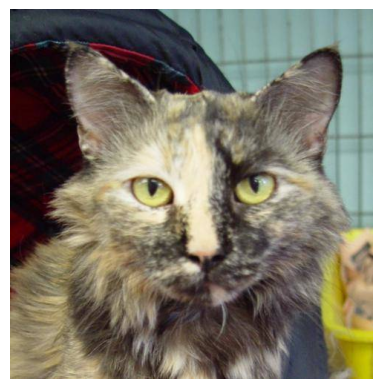

In [ ]:
image_path = '/content/dogs_vs_cats/test/cats/cat.10.jpg'
#Read Image
img = mpimg.imread(image_path)

print(img.shape)
#Display Image
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
#Image Parameters
img_size=224
batch_size=32

# Train Test Split

In [ ]:
#Image Data Generators
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2 # use 20% of data for validation
)

In [ ]:
# Train Generator
train_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='training',
    class_mode='categorical'
)

Found 4000 images belonging to 2 classes.


In [ ]:
# Validation Generator
validation_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,# batch size is group of images
    subset='validation',
    class_mode='categorical'
)

Found 1000 images belonging to 2 classes.


# Convolutional Neural Network

In [ ]:
# Model Definition
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))


model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(train_generator.num_classes, activation='softmax'))

In [ ]:
#model summary
model.summary()# none tells us about batch since we have not given any batch parameter

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 256)               4

In [ ]:
#compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
             )

# Model training

In [ ]:
# Training the Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,  # Number of steps per epoch
    epochs=6,  # Number of epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size  # Validation steps
)

Epoch 1/6
 49/125 [==========>...................] - ETA: 4:01 - loss: 0.1384 - accuracy: 0.9522

# Model Evaluation

In [ ]:
# Model Evaluation
print("Evaluating model...")
val_loss, val_accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

Evaluating model...
339/339 ━━━━━━━━━━━━━━━━━━━━ 72s 213ms/step - accuracy: 0.8914 - loss: 0.3407
Validation Accuracy: 89.29%


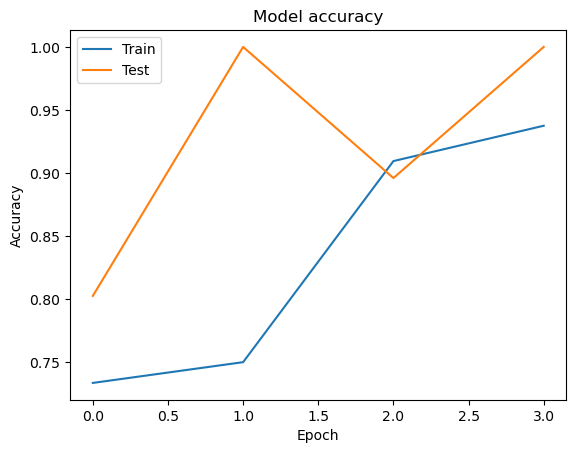

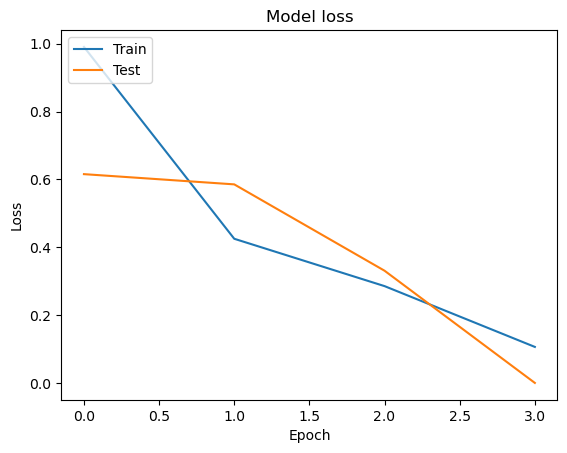

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Building a predictive system

In [ ]:
# Function to Load and Preprocess the Image using Pillow
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    # Load the image
    img = Image.open(image_path)
    # Resize the image
    img = img.resize(target_size)
    # Convert the image to a numpy array
    img_array = np.array(img)
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    # Scale the image values to [0, 1]
    img_array = img_array.astype('float32') / 255.
    return img_array

# Function to Predict the Class of an Image
def predict_image_class(model, image_path, class_indices):
    preprocessed_img = load_and_preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_indices[predicted_class_index]
    return predicted_class_name

In [ ]:
# Create a mapping from class indices to class names
class_indices = {v: k for k, v in train_generator.class_indices.items()}


class_indices

{0: 'Apple___Apple_scab',
 1: 'Apple___Black_rot',
 2: 'Apple___Cedar_apple_rust',
 3: 'Apple___healthy',
 4: 'Blueberry___healthy',
 5: 'Cherry_(including_sour)___Powdery_mildew',
 6: 'Cherry_(including_sour)___healthy',
 7: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 8: 'Corn_(maize)___Common_rust_',
 9: 'Corn_(maize)___Northern_Leaf_Blight',
 10: 'Corn_(maize)___healthy',
 11: 'Grape___Black_rot',
 12: 'Grape___Esca_(Black_Measles)',
 13: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 14: 'Grape___healthy',
 15: 'Orange___Haunglongbing_(Citrus_greening)',
 16: 'Peach___Bacterial_spot',
 17: 'Peach___healthy',
 18: 'Pepper,_bell___Bacterial_spot',
 19: 'Pepper,_bell___healthy',
 20: 'Potato___Early_blight',
 21: 'Potato___Late_blight',
 22: 'Potato___healthy',
 23: 'Raspberry___healthy',
 24: 'Soybean___healthy',
 25: 'Squash___Powdery_mildew',
 26: 'Strawberry___Leaf_scorch',
 27: 'Strawberry___healthy',
 28: 'Tomato___Bacterial_spot',
 29: 'Tomato___Early_blight',
 30: '

In [ ]:
# saving the class names as json file
json.dump(class_indices, open('class_indices.json', 'w'))

In [ ]:
# Example Usage
image_path = 'Test/test_apple_black_rot.JPG'
#image_path = 'test_blueberry_healthy.jpg'
#image_path = 'test_potato_early_blight.jpg'
predicted_class_name = predict_image_class(model, image_path, class_indices)

# Output the result
print("Predicted Class Name:", predicted_class_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Predicted Class Name: Apple___Black_rot


In [ ]:
# Model Saving

In [ ]:
model.save('plant_disease_prediction_model.keras')